In [ ]:
import pandas as pd
df= pd.read_csv('realistic_customer_churn.csv')
df.head()


,customer_id,tenure,num_transactions_last_month,avg_transaction_value,last_login_days_ago,late_payments,support_tickets_opened,region,plan_type,churn
0,1,45,6,1230.00,23,2,1,East,Premium,0
1,2,48,2,1429.43,20,2,0,South,VIP,0
2,3,54,7,676.98,22,3,3,East,Basic,0
3,4,1,5,1657.02,28,2,1,East,Basic,1
4,5,4,3,1214.64,18,3,4,East,VIP,1


In [31]:
# 🔧 Feature Engineering: Create meaningful new features

# 1. Total transaction value per customer (frequency * value)
df['total_transaction_value'] = df['num_transactions_last_month'] * df['avg_transaction_value']

# 2. Engagement score: how active and recent a customer is
df['engagement_score'] = df['num_transactions_last_month'] / (df['last_login_days_ago'] + 1)

# 3. Payment risk: normalized late payments by tenure
df['payment_risk'] = df['late_payments'] / (df['tenure'] + 1)

# 4. Support burden: support tickets per month of tenure
df['support_burden'] = df['support_tickets_opened'] / (df['tenure'] + 1)

# 5. Inactivity interaction with late payments (multi-risk)
df['inactivity_payment_combo'] = df['last_login_days_ago'] * df['late_payments']

# 6. Loyalty flag: customers with long tenure
df['is_loyal'] = (df['tenure'] > 36).astype(int)

# 7. High risk flag: multiple red flags (many late payments + support tickets)
df['high_risk_customer'] = ((df['late_payments'] > 2) & (df['support_tickets_opened'] > 1)).astype(int)

# 8. Engagement drop flag: very low activity recently
df['engagement_drop'] = ((df['last_login_days_ago'] > 20) & (df['num_transactions_last_month'] < 2)).astype(int)

# 9. Value per transaction
df['value_per_transaction'] = df['avg_transaction_value'] / (df['num_transactions_last_month'] + 1)

# 10. Binary flag for high value customers
df['high_value_customer'] = (df['avg_transaction_value'] > 1500).astype(int)


In [33]:
df.describe()

,customer_id,tenure,num_transactions_last_month,avg_transaction_value,last_login_days_ago,late_payments,support_tickets_opened,churn,total_transaction_value,engagement_score,payment_risk,support_burden,inactivity_payment_combo,is_loyal,high_risk_customer,engagement_drop,value_per_transaction,high_value_customer
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,29.897200,4.928200,1196.709426,14.894800,0.97620,1.006400,0.207800,5905.935228,0.507640,0.062221,0.066193,14.680200,0.396400,0.012400,0.011800,240.026549,0.15640
std,1443.520003,17.108266,2.224148,296.009774,8.308883,0.87988,0.998678,0.405773,3141.738821,0.582851,0.125465,0.140941,17.482067,0.489198,0.110674,0.107996,144.301513,0.36327
min,1.000000,1.000000,0.000000,48.330000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.055000,0.00000
25%,1250.750000,15.000000,3.000000,999.977500,8.000000,0.00000,0.000000,0.000000,3611.660000,0.185185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.807071,0.00000
50%,2500.500000,30.000000,5.000000,1196.415000,15.000000,1.00000,1.000000,0.000000,5467.315000,0.310345,0.027027,0.025641,10.000000,0.000000,0.000000,0.000000,207.172976,0.00000
75%,3750.250000,45.000000,6.000000,1391.117500,22.000000,2.00000,2.000000,0.000000,7636.740000,0.571429,0.062500,0.066667,23.000000,1.000000,0.000000,0.000000,282.711250,0.00000
max,5000.000000,59.000000,17.000000,2328.440000,29.000000,4.00000,7.000000,1.000000,24928.970000,5.500000,1.500000,2.000000,116.000000,1.000000,1.000000,1.000000,1886.630000,1.00000


In [34]:
df['churn'].value_counts()

churn
0    3961
1    1039
Name: count, dtype: int64

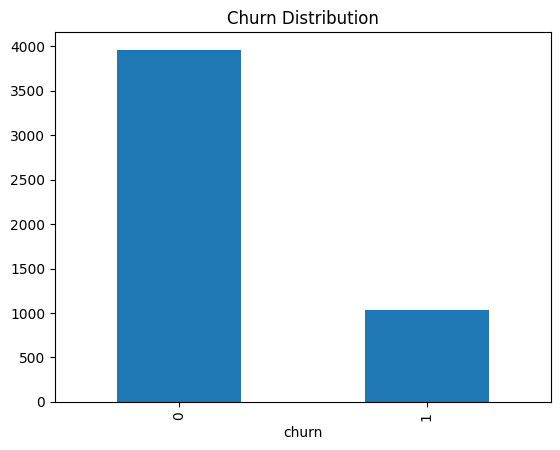

In [35]:
import matplotlib.pyplot as plt
df['churn'].value_counts().plot(kind='bar', title='Churn Distribution')
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
X = df.drop(['customer_id', 'churn'],axis=1)
y=df['churn']
categorical_cols = ['region', 'plan_type']
numeric_cols = [col for col in X.columns if col not in categorical_cols]
categorical_cols += ['is_loyal', 'high_risk_customer', 'engagement_drop', 'high_value_customer']
numeric_cols = [col for col in df.columns if col not in ['churn', 'customer_id'] + categorical_cols]

# One-hot encode categorical features
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
], remainder='passthrough')  # Keep numeric features unchanged

# Create pipeline with preprocessing + model
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [37]:
model_pipeline.fit(X_train, y_train)

# Predict
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("✅ Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Model Evaluation
Accuracy: 0.798
ROC AUC: 0.7116478571567115

Confusion Matrix:
 [[1155   44]
 [ 259   42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.88      1199
           1       0.49      0.14      0.22       301

    accuracy                           0.80      1500
   macro avg       0.65      0.55      0.55      1500
weighted avg       0.75      0.80      0.75      1500



In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print('best accuracy:', grid.best_score_)


Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
best accuracy: 0.7330112842380064
